# Ejercicio 9

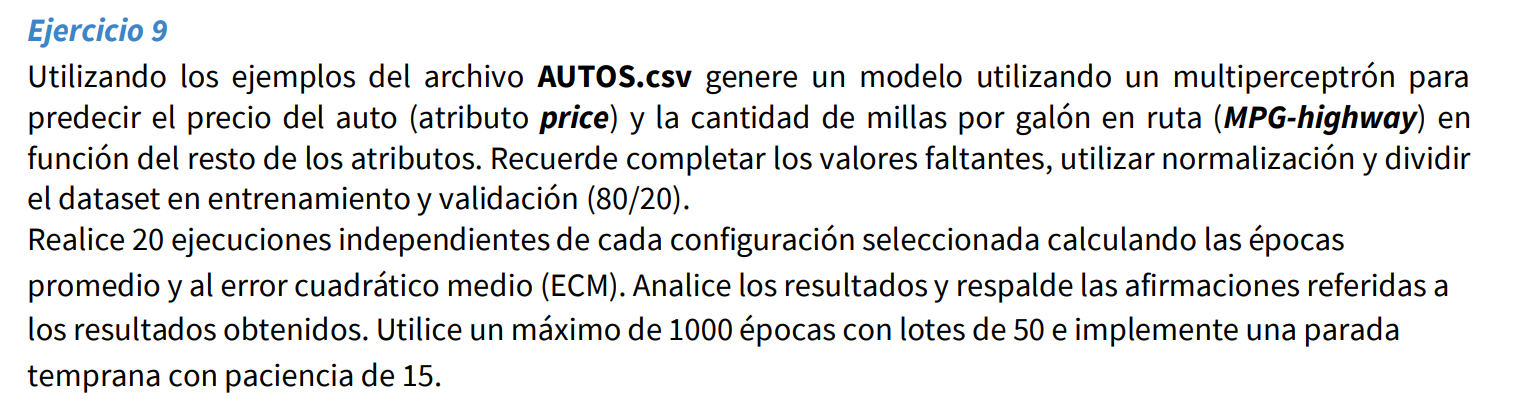

### Lectura de datos e importe de librerias

In [56]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

In [67]:
import pandas as pd      # para trabajar con archivos de datos csv, excel, etc: https://pandas.pydata.org/docs/getting_started/tutorials.html
import chardet           # para detectar la codificación de texto en archivos
import numpy as np

nombre_archivo = DATOS_DIR + 'AUTOS.csv' # 

#-- detectando la codificación de caracteres usada ----
with open(nombre_archivo, 'rb') as f:
    result = chardet.detect(f.read())  # or readline if the file is large

# recupera el archivo en un objeto dataframe de pandas utilizando la codificación detectada
df = pd.read_csv(nombre_archivo, encoding=result['encoding'], sep=',')

df.head()

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling
0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,3
1,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,3
2,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,1
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,2
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,2


In [69]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten, Input, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
from sklearn import preprocessing, metrics, model_selection 
import pandas as pd
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import chardet
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Input, LeakyReLU


# Analisis del dataset

In [70]:
# muestra cantidad de valores faltantes o nulos por atributo/característica
print(df.isnull().sum())


values = {'normalized-losses': df['normalized-losses'].mean(),
          'bore': df['bore'].mean(),
          'stroke': df['stroke'].mean(),
          'horsepower': df['horsepower'].mean(),
          'peak-rpm': df['peak-rpm'].mean(),
          'price': df['price'].mean()}

# reemplaza valores nulos por los indicados en el diccionario values
df = df.fillna(value=values)

normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
symboling             0
dtype: int64


In [71]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

Reemplazo los valores categoricos por numeros usando el label encoder

In [73]:
variables_a_predecir = [12,14] #12 mpg-highway y 14 price
datos = np.array(df)
Y = datos[:, variables_a_predecir]
X = np.delete(datos, variables_a_predecir, 1) #elimino las columnas de los atributos a predecir

In [74]:
normalizarEntrada = 1
if normalizarEntrada:
    data_scaler, target_scaler = StandardScaler(), StandardScaler()
    X = data_scaler.fit_transform(X)
    Y = target_scaler.fit_transform(Y)

In [75]:
lista_epocas = []
lista_mse = []
for i in range(20):
    # %% Separa los datos y clase en grupo de entrenamiento y validacion
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2,  shuffle = True)

    #parametros
    6# cantidad de pasadas de los datos
    EPOCAS = 1000
    # cantidad de datos a procesar para actualizar pesos
    TAM_LOTE = 64

    ENTRADAS = X.shape[1]
    SALIDAS = len(variables_a_predecir)

    ACTIVACION = LeakyReLU()
    #ACTIVACION = 'ReLU'
    #ACTIVACION = 'tanh'
    #ACTIVACION = 'sigmoid'

    #OPTIMIZADOR = 'sgd'
    OPTIMIZADOR = 'rmsprop'
    #OPTIMIZADOR = 'adam'
    PACIENCIA = 15

    #modelo
    model = Sequential()
    model.add(Input(shape=(ENTRADAS,)))
    model.add(Dense(6, activation=ACTIVACION))
    model.add(Dense(3, activation= ACTIVACION))
    model.add(Dense(SALIDAS))

    #compilacion
    model.compile(optimizer=OPTIMIZADOR, loss='mse', metrics = ['accuracy', 'mae', 'mse'])

    # El parámetro patience indica la cantidad de epocas que deben transcurrir
    # sin mejoras en el entrenamiento
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA)

    # entrenamiento (me guardo la historia del modelo)
    history = model.fit(x = x_train, y = y_train, batch_size = TAM_LOTE, epochs = EPOCAS,
                validation_data = (x_val, y_val), callbacks=[early_stop])
    
    #agrego a la lista
    lista_epocas.append(len(history.epoch)) #agrego la cantidad de epocas de la iteracion a la lista
    lista_mse.append(history.history['mse'][-1])
    

print(f"Modelo con activación {ACTIVACION} y optimizador {OPTIMIZADOR}")
print("Media de epocas utilizadas: %6.2f" % np.mean(lista_epocas))
print("Media de ECM: %9.5f" % np.mean(lista_mse))


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.3387 - loss: 1.9723 - mae: 1.0529 - mse: 1.9723 - val_accuracy: 0.3415 - val_loss: 2.4641 - val_mae: 1.1326 - val_mse: 2.4641
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3680 - loss: 1.8688 - mae: 1.0281 - mse: 1.8688 - val_accuracy: 0.3415 - val_loss: 2.3138 - val_mae: 1.0936 - val_mse: 2.3138
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3704 - loss: 1.6219 - mae: 0.9643 - mse: 1.6219 - val_accuracy: 0.3415 - val_loss: 2.1986 - val_mae: 1.0610 - val_mse: 2.1986
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3676 - loss: 1.6558 - mae: 0.9564 - mse: 1.6558 - val_accuracy: 0.3659 - val_loss: 2.1074 - val_mae: 1.0337 - val_mse: 2.1074
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3904 - loss: 1.5354 - mae: 0.9302 - mse: 1.5354 - val_accuracy: 0.3659 - val_loss: 2.0272 - val_mae: 1.0094 - val_mse: 2.0272
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms